In [1]:
import os
import time
from datetime import datetime
import pandas as pd
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as torch_utils
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# custom weights initialization
# Reference (PyTorch Tutorials)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def save_images(images, output_dir):
    print('Saving Images...')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for idx, img in enumerate(images):
        img = img.permute(1, 2, 0)
        img = img.numpy()
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S_%f')
        filename = f'image_{timestamp}_{idx}.png'
        filepath = os.path.join(output_dir, filename)
        plt.imsave(filepath, img)
    print("Done!")
    return True

In [3]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, classes) -> None:
        super(Discriminator, self).__init__()
        self.classes = classes

        self.embedding = nn.Linear(classes, 1*64*64)

        conv_1 = self.conv_block(4, 64)
        conv_2 = self.conv_block(64, 128)
        conv_3 = self.conv_block(128, 256)
        conv_4 = self.conv_block(256, 512)

        self.classifier = nn.Sequential(
            conv_1,
            conv_2,
            conv_3,
            conv_4,
            nn.Conv2d(512, 1024, (5, 5), 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (5, 5), 2, 2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
    
    def forward(self, x, label):
        label_embedding = self.embedding(label).view(-1, 1, 64, 64)
        comb_latent_vector = torch.concat((x, label_embedding), dim=1)
        output = self.classifier(comb_latent_vector)
        return output

In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self, classes):
        super(Generator, self).__init__()
        self.classes = classes

        self.embedding = nn.Linear(classes, 8*8)

        self.latent_vector = nn.Sequential(
            nn.Linear(100, 512*8*8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        upsample_1 = self.upsample_block(513, 256, 1)
        upsample_2 = self.upsample_block(256, 128, 1)
        upsample_3 = self.upsample_block(128, 64, 1)

        self.conv_model = nn.Sequential(
            upsample_1,
            upsample_2,
            upsample_3,
            nn.Conv2d(64, 3, (1, 1), 1, 0),
            nn.Tanh()
        )
    
    def upsample_block(self, in_channels, out_channels, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, (4, 4), 2, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x, label):
        latent_vector = self.latent_vector(x).view(-1, 512, 8, 8)
        label_embedding = self.embedding(label).view(-1, 1, 8, 8)
        comb_latent_vector = torch.concat((latent_vector, label_embedding), dim = 1)
        output = self.conv_model(comb_latent_vector)
        return output

In [5]:
manualSeed = 123
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
beta1 = 0.5
batch_size = 16
noise_dim = 100
workers = 2

In [7]:
# Monitor Progress
def train(dataloader, classes):
    progress = list()
    fixed_noise = torch.randn(classes*10, noise_dim, device=device)
    fixed_labels = []
    for i in range(classes):
        lab = [0 if j != i else 1 for j in range(classes)]
        lab = lab*10
        fixed_labels.append(lab)
    fixed_labels = torch.Tensor(fixed_labels).view(classes*10, classes).float().to(device)

    disc_net = Discriminator(classes)
    gen_net = Generator(classes)
    disc_net.to(device)
    gen_net.to(device)
    disc_net.apply(weights_init)
    gen_net.apply(weights_init)

    criterion = nn.BCELoss()

    disc_optimizer = optim.Adam(disc_net.parameters(), lr=lr, betas=(beta1, 0.999))
    gen_optimizer = optim.Adam(gen_net.parameters(), lr=lr, betas=(beta1, 0.999))


    # Training Loop

    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0
    
    disc_net.train()
    gen_net.train()
    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            real_images = data[0].to(device)
            real_labels = data[1].to(device)
            num_images = real_images.size(0)
            
            real_target = torch.ones(num_images,).to(device)
            fake_target = torch.zeros(num_images,).to(device)
            
            # Training the discriminator
            # Train Discriminator on Real Images and Fake Images
            disc_net.zero_grad()

            real_output = disc_net(real_images, real_labels).view(-1)
            disc_err_real = criterion(real_output, real_target)
            
            # Conditional Noise
            noise = torch.randn(num_images, noise_dim, device=device)

            fake = gen_net(noise, real_labels)

            fake_output = disc_net(fake.detach(), real_labels).view(-1)
            disc_err_fake = criterion(fake_output, fake_target)

            disc_err = (disc_err_real + disc_err_fake)/2
            disc_err.backward()
            disc_optimizer.step()

            # Training the Generator
            # Steps:
            # 1. Get Discriminator Predictions on Fake Images
            # 2. Calculate loss
            gen_net.zero_grad()
            
            output = disc_net(fake, real_labels).view(-1)

            gen_err = criterion(output, real_target)
            gen_err.backward()
            gen_optimizer.step()

            # Training Update
            if i % 50 == 0:
                print(
                    f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {disc_err.item()}\tLoss_G: {gen_err.item()}"
                )

            # Tracking loss
            G_losses.append(gen_err.item())
            D_losses.append(disc_err.item())

            # Tracking Generator Progress
            if (iters % 20 == 0) or (
                (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
            ):
                gen_net.eval()
                with torch.no_grad():
                    fake = gen_net(fixed_noise, fixed_labels).detach().cpu()
                progress.append(torch_utils.make_grid(fake, padding=2, nrow=10, normalize=True))
                gen_net.train()
            iters += 1
            
    return gen_net, G_losses, D_losses, progress


In [8]:
def eval(classes, model_path, num_images, output_dir):
    fixed_noise = torch.randn(classes*10, noise_dim, device=device)
    fixed_labels = []
    for i in range(classes):
        lab = [0 if j != i else 1 for j in range(classes)]
        lab = lab*10
        fixed_labels.append(lab)
    fixed_labels = torch.Tensor(fixed_labels).view(classes*10, classes).float().to(device)

    gen_net = Generator(classes)
    gen_net.to(device)
    gen_net.load_state_dict(torch.load(model_path))

    iters = 0
    
    gen_net.eval()
    images = []
    print("Starting Inference Loop...")
    for image in range(num_images):
        with torch.no_grad():
            fake = gen_net(fixed_noise, fixed_labels).detach().cpu()
        images.append(torch_utils.make_grid(fake, padding=2, nrow=10, normalize=True))
         
    return save_images(images, output_dir)

## Dataset 1: Hindi MNIST

In [9]:
def target_to_oh_mnist(target):
    NUM_CLASS = 10
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot

In [10]:
lr = 1e-3
num_epochs = 5
batch_size = 64
data_dir = "/kaggle/input/mnistasjpg/trainingSet/trainingSet"
model_save_path = "/kaggle/working/cgan_mnist.pt"
animation_save_path = "/kaggle/working/cgan_mnist.mp4"
training_plot_save_path = "/kaggle/working/cgan_mnist.png"

mnist_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    target_transform = target_to_oh_mnist
)


mnist_dataloader = data.DataLoader(
    mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

In [11]:
mnist_gen_net, mnist_G_losses, mnist_D_losses, mnist_progress = train(mnist_dataloader, 10)

Starting Training Loop...
[0/5][0/657]	Loss_D: 0.7054235339164734	Loss_G: 0.9467443227767944
[0/5][50/657]	Loss_D: 0.501679539680481	Loss_G: 1.2264684438705444
[0/5][100/657]	Loss_D: 0.4283689260482788	Loss_G: 1.2596585750579834
[0/5][150/657]	Loss_D: 0.24133512377738953	Loss_G: 1.9725754261016846
[0/5][200/657]	Loss_D: 0.4032849669456482	Loss_G: 1.7195879220962524
[0/5][250/657]	Loss_D: 0.2851189970970154	Loss_G: 2.5473904609680176
[0/5][300/657]	Loss_D: 0.14521019160747528	Loss_G: 3.6950881481170654
[0/5][350/657]	Loss_D: 0.05259738117456436	Loss_G: 3.7054190635681152
[0/5][400/657]	Loss_D: 0.5877215266227722	Loss_G: 2.5100371837615967
[0/5][450/657]	Loss_D: 0.04850627854466438	Loss_G: 3.5807600021362305
[0/5][500/657]	Loss_D: 0.02340833656489849	Loss_G: 4.2642822265625
[0/5][550/657]	Loss_D: 0.020022599026560783	Loss_G: 4.345296859741211
[0/5][600/657]	Loss_D: 0.012306321412324905	Loss_G: 5.039794921875
[0/5][650/657]	Loss_D: 0.014213860034942627	Loss_G: 4.878448009490967
[1/5][0/65

In [12]:
# Save generator
torch.save(mnist_gen_net.state_dict(), model_save_path)

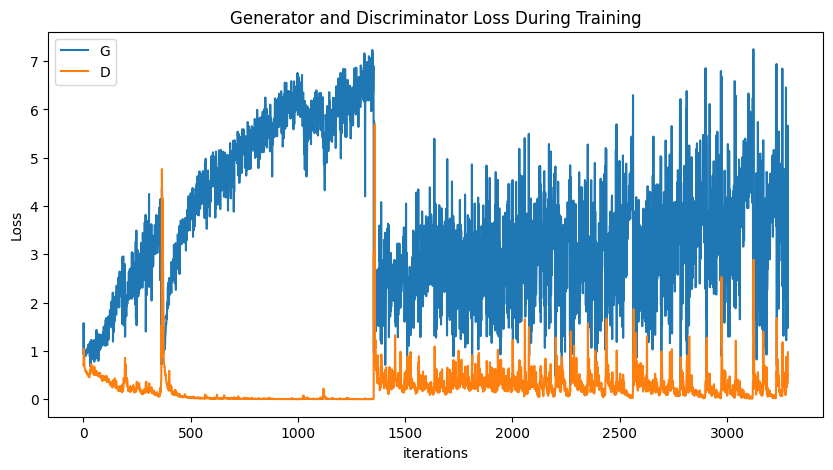

In [13]:
# Plot Training Graph
fig1 = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(mnist_G_losses, label="G")
plt.plot(mnist_D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()

In [14]:
del mnist_dataset
del mnist_dataloader

In [15]:
# Progress Animation

fig2 = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in mnist_progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=5)
anim.save(animation_save_path, writer=writervideo)
plt.close()


In [16]:
eval(10, '/kaggle/working/cgan_mnist.pt', 5, '/kaggle/working/mnist_eval')

Starting Inference Loop...
Saving Images...
Done!


True

In [17]:
del mnist_progress

## Dataset 2: Flower Dataset

In [18]:
def target_to_oh_flower(target):
    NUM_CLASS = 5
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot

In [19]:
lr = 2e-3
num_epochs = 60
batch_size = 16
data_dir = "/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification/Flower Classification/Training Data"
model_save_path = "/kaggle/working/cgan_flowers.pt"
animation_save_path = "/kaggle/working/cgan_flowers.mp4"
training_plot_save_path = "/kaggle/working/cgan_flowers.png"

flower_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    target_transform = target_to_oh_flower
)

flower_dataloader = data.DataLoader(
    flower_dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

In [20]:
flower_gen_net, flower_G_losses, flower_D_losses, flower_progress = train(flower_dataloader, 5)

Starting Training Loop...
[0/60][0/313]	Loss_D: 0.7852136492729187	Loss_G: 1.197787880897522
[0/60][50/313]	Loss_D: 0.729189932346344	Loss_G: 0.7545576095581055
[0/60][100/313]	Loss_D: 0.686614990234375	Loss_G: 0.7009354829788208
[0/60][150/313]	Loss_D: 0.7523671388626099	Loss_G: 0.787011444568634
[0/60][200/313]	Loss_D: 0.67387855052948	Loss_G: 0.6655372381210327
[0/60][250/313]	Loss_D: 0.7232022285461426	Loss_G: 0.7429212927818298
[0/60][300/313]	Loss_D: 0.7239508628845215	Loss_G: 0.727798581123352
[1/60][0/313]	Loss_D: 0.7034854888916016	Loss_G: 0.7205784320831299
[1/60][50/313]	Loss_D: 0.7175984382629395	Loss_G: 0.9574065208435059
[1/60][100/313]	Loss_D: 0.8274708986282349	Loss_G: 0.689441978931427
[1/60][150/313]	Loss_D: 0.7446763515472412	Loss_G: 0.7040387392044067
[1/60][200/313]	Loss_D: 0.749445915222168	Loss_G: 0.7974368929862976
[1/60][250/313]	Loss_D: 0.6624312996864319	Loss_G: 0.7848585844039917
[1/60][300/313]	Loss_D: 0.7538251876831055	Loss_G: 0.950778603553772
[2/60][0/3

In [21]:
# Save generator
torch.save(flower_gen_net.state_dict(), model_save_path)

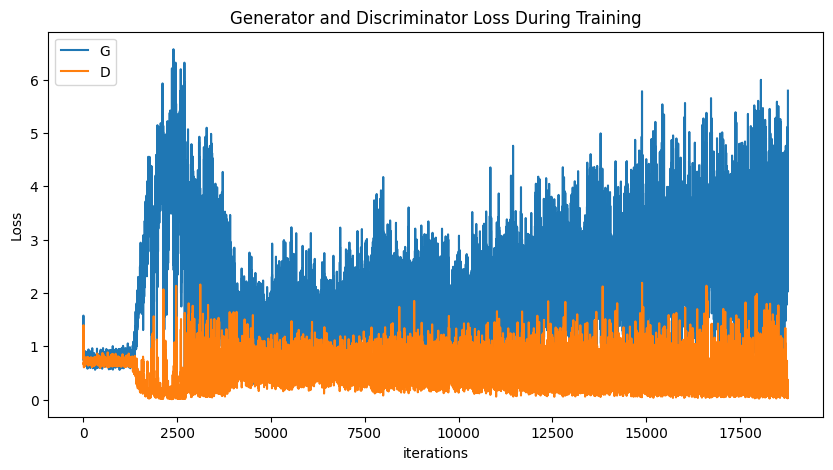

In [22]:
# Plot Training Graph
fig1 = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(flower_G_losses, label="G")
plt.plot(flower_D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()

In [23]:
# Progress Animation
fig2 = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in flower_progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=5)
anim.save(animation_save_path, writer=writervideo)
plt.close()

In [24]:
eval(5, '/kaggle/working/cgan_flowers.pt', 5, '/kaggle/working/flower_eval')

Starting Inference Loop...
Saving Images...
Done!


True

In [25]:
del flower_dataset
del flower_dataloader

## Dataset 3: Shoe, Sandal, Boot

In [26]:
def target_to_oh_shoe(target):
    NUM_CLASS = 3
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot

In [27]:
lr = 2e-3
num_epochs = 25
batch_size = 16
data_dir = "/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset"
model_save_path = "/kaggle/working/cgan_shoe.pt"
animation_save_path = "/kaggle/working/cgan_shoe.mp4"
training_plot_save_path = "/kaggle/working/cgan_shoe.png"
# os.mkdir(model_save_path)

shoe_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    target_transform = target_to_oh_shoe
)

shoe_dataloader = data.DataLoader(
    shoe_dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

In [28]:
shoe_gen_net, shoe_G_losses, shoe_D_losses, shoe_progress = train(shoe_dataloader, 3)

Starting Training Loop...
[0/25][0/938]	Loss_D: 0.6691993474960327	Loss_G: 0.9517217874526978
[0/25][50/938]	Loss_D: 0.7119049429893494	Loss_G: 0.7890450358390808
[0/25][100/938]	Loss_D: 0.7287557125091553	Loss_G: 0.7044015526771545
[0/25][150/938]	Loss_D: 0.6937763690948486	Loss_G: 0.7237331867218018
[0/25][200/938]	Loss_D: 0.6379410624504089	Loss_G: 0.8427118062973022
[0/25][250/938]	Loss_D: 0.638427734375	Loss_G: 0.826932966709137
[0/25][300/938]	Loss_D: 0.6592453718185425	Loss_G: 0.7491919994354248
[0/25][350/938]	Loss_D: 0.5694388151168823	Loss_G: 1.021768569946289
[0/25][400/938]	Loss_D: 0.5488841533660889	Loss_G: 0.9336766004562378
[0/25][450/938]	Loss_D: 0.3304290771484375	Loss_G: 1.670964241027832
[0/25][500/938]	Loss_D: 0.6134458780288696	Loss_G: 1.2755060195922852
[0/25][550/938]	Loss_D: 0.6478133201599121	Loss_G: 0.8494941592216492
[0/25][600/938]	Loss_D: 0.8133069276809692	Loss_G: 1.3652191162109375
[0/25][650/938]	Loss_D: 0.21458084881305695	Loss_G: 2.0847437381744385
[0/

In [29]:
# Save generator
torch.save(shoe_gen_net.state_dict(), model_save_path)

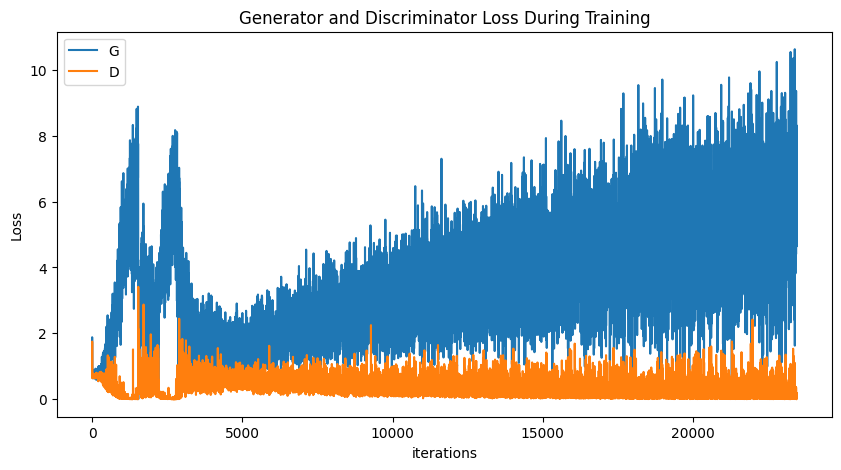

In [30]:
# Plot Training Graph
fig1 = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(shoe_G_losses, label="G")
plt.plot(shoe_D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()

In [31]:
# Progress Animation
fig2 = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in shoe_progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=5)
anim.save(animation_save_path, writer=writervideo)
plt.close()

In [32]:
eval(3, '/kaggle/working/cgan_shoe.pt', 5, '/kaggle/working/shoe_eval')

Starting Inference Loop...
Saving Images...
Done!


True

In [33]:
del shoe_dataset
del shoe_dataloader